**OBJECTIVE:** Recreate pictures and tables in the manuscript

In [50]:
import numpy as np
import pandas as pd
import igraph as ig

from modSAR.network_algorithms import ModSAR
from modSAR.dataset import QSARDatasetIO
from scripts.validation import DataSplit

from sklearn.externals import joblib

from plotnine import *
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

DATASETS = ['NYPR1', 'NYPR2', 'CHRM3', 'hDHFR', 'rDHFR']
ALGORITHMS = ['modsar', 'svm', 'rf']

qsar_datasets = \
{dataset_name:
    QSARDatasetIO.load(dataset_name=dataset_name, 
                       filepath='/mnt/data/%s.xlsx' % dataset_name, 
                       calculate_similarity=False)
 for dataset_name in DATASETS
}

# Data Input and Preparation

In [2]:
# Read spreadsheets containing test results
dataset_results = []
for dataset_name in DATASETS:
    for algorithm in ALGORITHMS:
        for i in range(1, 5+1):
            dataset_results.append(pd.read_excel('/mnt/data/results/%s/results_%s_split%02d_alg_%s.xlsx' % 
                                                 (dataset_name, dataset_name, i, algorithm)))
dataset_results = pd.concat(dataset_results, sort=False)
dataset_results['dataset'] = pd.Categorical(dataset_results['dataset'], categories=DATASETS)

In [3]:
data_splits = {
    dataset_name: DataSplit(qsar_dataset, filename='/mnt/data/%s_splits.xlsx' % dataset_name)
    for dataset_name, qsar_dataset in qsar_datasets.items()}

In [4]:
# Read best regression models generated by the algorithm for each data split
best_models = \
{algorithm: {dataset_name :
    [joblib.load('/mnt/data/results/%s/%s_split%02d_alg_%s.joblib' % (dataset_name, dataset_name, i, algorithm)) 
     for i in range(1, 5+1)]
 for dataset_name in DATASETS
} for algorithm in ALGORITHMS}

# Tables

## Table 2 - Network characteristics

Statistics of networks created in every test

In [5]:
def get_network_stats(name, i, g):
    modules = pd.Series(g.vs['louvain']).value_counts()
    return pd.DataFrame({'dataset' : name, 
                         'data_split': i + 1,
                         'nodes': len(g.vs),
                         'density': g.density(),
                         'threshold': g['threshold'],
                         'ACC': g['globalClusteringCoefficient'],
                         'modularity': g.modularity(pd.Categorical(g.vs['louvain']).codes),
                         'number_main_modules': len(modules[modules != 1]),
                         'number_singletons': len(modules[modules == 1]),
                         'average_degree': np.mean(g.degree()),
                         'average_path_length': g.average_path_length(),
                         'degree_assortativity': g.assortativity_degree()},
                        index=[0])

network_stats = []

for dataset_name in DATASETS:
    for i in range(5):
        network_stats.append(get_network_stats(dataset_name, i, best_models['modsar'][dataset_name][i].instance_graph))

network_stats = pd.concat(network_stats)
network_stats['dataset'] = pd.Categorical(network_stats['dataset'], categories=qsar_datasets)

### Alternative 1: Ranges

In [6]:
int_cols = ['nodes', 'number_main_modules', 'number_singletons']

def value_ranges(data):
    stats = data.describe()
    features = stats.columns.tolist()
    return pd.Series({feat: '[%.2f - %.2f]' % (stats[feat].loc['min'], stats[feat].loc['max']) if feat not in int_cols 
                      else '[%d - %d]' % (stats[feat].loc['min'], stats[feat].loc['max']) for feat in features})

network_stats_range = network_stats.drop(columns=['data_split']).groupby(['dataset']).apply(value_ranges)
network_stats_range

,nodes,density,threshold,ACC,modularity,number_main_modules,number_singletons,average_degree,average_path_length,degree_assortativity
dataset,,,,,,,,,,
NYPR1,[247 - 248],[0.05 - 0.07],[0.24 - 0.28],[0.63 - 0.65],[0.77 - 0.81],[11 - 20],[23 - 57],[12.65 - 16.15],[1.64 - 4.95],[0.58 - 0.79]
NYPR2,[256 - 257],[0.11 - 0.14],[0.25 - 0.28],[0.68 - 0.73],[0.57 - 0.63],[7 - 14],[17 - 40],[29.41 - 35.30],[2.74 - 2.95],[0.78 - 0.91]
CHRM3,[434 - 436],[0.08 - 0.10],[0.30 - 0.31],[0.72 - 0.75],[0.54 - 0.62],[14 - 18],[20 - 28],[36.17 - 43.09],[3.52 - 4.19],[0.64 - 0.69]
hDHFR,[377 - 379],[0.10 - 0.10],[0.34 - 0.35],[0.73 - 0.76],[0.63 - 0.66],[11 - 12],[4 - 7],[36.52 - 39.22],[2.75 - 2.85],[0.46 - 0.53]
rDHFR,[596 - 597],[0.06 - 0.08],[0.37 - 0.40],[0.64 - 0.65],[0.63 - 0.69],[7 - 11],[1 - 3],[37.37 - 48.79],[2.70 - 3.06],[0.47 - 0.51]


In [7]:
# print(network_stats_range.to_latex())

### Alternative 2: Mean $\pm$ STD

In [8]:
def mean_std(data):
    stats = data.describe()
    features = stats.columns.tolist()
    return pd.Series({feat: '%.2f (\pm %.2f)$' % (stats[feat].loc['mean'], stats[feat].loc['std']) 
                      for feat in features})

network_stats_df = network_stats.drop(columns=['data_split']).groupby(['dataset']).apply(mean_std)
network_stats_df

,nodes,density,threshold,ACC,modularity,number_main_modules,number_singletons,average_degree,average_path_length,degree_assortativity
dataset,,,,,,,,,,
NYPR1,247.40 (\pm 0.55)$,0.06 (\pm 0.01)$,0.25 (\pm 0.02)$,0.64 (\pm 0.01)$,0.78 (\pm 0.02)$,13.60 (\pm 3.78)$,32.00 (\pm 14.28)$,15.16 (\pm 1.45)$,3.95 (\pm 1.32)$,0.67 (\pm 0.08)$
NYPR2,256.60 (\pm 0.55)$,0.13 (\pm 0.01)$,0.26 (\pm 0.01)$,0.69 (\pm 0.02)$,0.60 (\pm 0.03)$,10.40 (\pm 2.70)$,25.80 (\pm 9.83)$,31.97 (\pm 2.18)$,2.81 (\pm 0.09)$,0.83 (\pm 0.06)$
CHRM3,434.80 (\pm 0.84)$,0.09 (\pm 0.01)$,0.31 (\pm 0.00)$,0.73 (\pm 0.01)$,0.58 (\pm 0.04)$,16.60 (\pm 1.67)$,23.80 (\pm 3.03)$,40.18 (\pm 2.71)$,3.84 (\pm 0.30)$,0.67 (\pm 0.02)$
hDHFR,377.80 (\pm 0.84)$,0.10 (\pm 0.00)$,0.35 (\pm 0.01)$,0.75 (\pm 0.01)$,0.65 (\pm 0.01)$,11.40 (\pm 0.55)$,5.60 (\pm 1.34)$,37.55 (\pm 1.12)$,2.81 (\pm 0.05)$,0.49 (\pm 0.03)$
rDHFR,596.80 (\pm 0.45)$,0.08 (\pm 0.01)$,0.38 (\pm 0.01)$,0.64 (\pm 0.00)$,0.65 (\pm 0.02)$,8.40 (\pm 1.67)$,2.20 (\pm 0.84)$,44.80 (\pm 4.40)$,2.79 (\pm 0.15)$,0.50 (\pm 0.01)$


## Table 3 - Performance in external set

## Table S1 - Cross Validation Results

In [9]:
dataset_results.head()

,splitStrategy,splitNumber,dataset,datasetVersion,fold,algorithm,algorithm_version,internal,no_modules,no_classes,threshold,train_mae,test_mae,train_rmse,test_rmse,fit_time,beta,lambda,algorithmVersion,params
0,1,1,NYPR1,default,1,modSAR,v0.1,True,40.0,60.0,0.24,0.105930,0.603444,0.356704,0.925563,51.595313,0.03,0.005,NaN,NaN
1,1,1,NYPR1,default,1,modSAR,v0.1,True,40.0,65.0,0.24,0.364761,0.794514,0.681562,1.160931,21.082392,0.03,0.050,NaN,NaN
2,1,1,NYPR1,default,1,modSAR,v0.1,True,40.0,49.0,0.24,0.550385,0.651250,0.909222,0.987716,8.814755,0.03,0.100,NaN,NaN
3,1,1,NYPR1,default,2,modSAR,v0.1,True,39.0,70.0,0.24,0.119399,0.862748,0.354709,1.399845,67.931351,0.03,0.005,NaN,NaN
4,1,1,NYPR1,default,2,modSAR,v0.1,True,39.0,74.0,0.24,0.326296,0.595404,0.601451,0.939482,59.158343,0.03,0.050,NaN,NaN


In [10]:
def internal_training_results(data, cols=['train_mae']):
    return pd.Series(
        {feat: '$%.2f (\pm %.2f)$' % (np.mean(data[feat]), np.std(data[feat])) 
                      for feat in cols}
    )

### Internal Training - MAE

In [11]:
training_df = \
    dataset_results.query('internal == True & algorithm == "modSAR"')\
    .groupby(['dataset', 'splitNumber']).apply(internal_training_results)
    
training_df = \
    training_df.reset_index().melt(id_vars=['dataset', 'splitNumber'])\
    .pivot_table(values='value', index='splitNumber', columns=['dataset', 'variable'], aggfunc='first')
training_df

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
variable,train_mae,train_mae,train_mae,train_mae,train_mae
splitNumber,,,,,
1,$0.33 (\pm 0.18)$,$0.36 (\pm 0.17)$,$0.46 (\pm 0.12)$,$0.58 (\pm 0.18)$,$0.52 (\pm 0.14)$
2,$0.30 (\pm 0.17)$,$0.35 (\pm 0.15)$,$0.49 (\pm 0.13)$,$0.59 (\pm 0.20)$,$0.49 (\pm 0.14)$
3,$0.21 (\pm 0.11)$,$0.34 (\pm 0.16)$,$0.47 (\pm 0.12)$,$0.60 (\pm 0.20)$,$0.51 (\pm 0.14)$
4,$0.31 (\pm 0.16)$,$0.34 (\pm 0.15)$,$0.50 (\pm 0.14)$,$0.61 (\pm 0.17)$,$0.50 (\pm 0.13)$
5,$0.31 (\pm 0.16)$,$0.30 (\pm 0.13)$,$0.48 (\pm 0.13)$,$0.60 (\pm 0.19)$,$0.51 (\pm 0.14)$


In [12]:
# print(training_df.to_latex())

### Internal Validation - MAE

In [13]:
training_df = \
    dataset_results.query('internal == True & algorithm == "modSAR"')\
    .groupby(['dataset', 'splitNumber'])\
    .apply(lambda x: internal_training_results(x, cols=['test_mae']))
    
training_df = \
    training_df.reset_index().melt(id_vars=['dataset', 'splitNumber'])\
    .pivot_table(values='value', index='splitNumber', columns=['dataset', 'variable'], aggfunc='first')
training_df

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
variable,test_mae,test_mae,test_mae,test_mae,test_mae
splitNumber,,,,,
1,$0.76 (\pm 0.20)$,$0.70 (\pm 0.20)$,$0.76 (\pm 0.14)$,$0.79 (\pm 0.12)$,$0.68 (\pm 0.09)$
2,$0.72 (\pm 0.19)$,$0.66 (\pm 0.18)$,$0.80 (\pm 0.16)$,$0.82 (\pm 0.10)$,$0.66 (\pm 0.09)$
3,$0.73 (\pm 0.17)$,$0.61 (\pm 0.12)$,$0.74 (\pm 0.16)$,$0.84 (\pm 0.11)$,$0.68 (\pm 0.10)$
4,$0.75 (\pm 0.21)$,$0.63 (\pm 0.12)$,$0.79 (\pm 0.13)$,$0.85 (\pm 0.10)$,$0.67 (\pm 0.10)$
5,$0.71 (\pm 0.20)$,$0.62 (\pm 0.12)$,$0.80 (\pm 0.22)$,$0.84 (\pm 0.12)$,$0.66 (\pm 0.09)$


### Internal Training - RMSE

In [14]:
training_df = \
    dataset_results.query('internal == True & algorithm == "modSAR"')\
    .groupby(['dataset', 'splitNumber'])\
    .apply(lambda x: internal_training_results(x, cols=['train_rmse']))
    
training_df = \
    training_df.reset_index().melt(id_vars=['dataset', 'splitNumber'])\
    .pivot_table(values='value', index='splitNumber', columns=['dataset', 'variable'], aggfunc='first')
training_df

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
variable,train_rmse,train_rmse,train_rmse,train_rmse,train_rmse
splitNumber,,,,,
1,$0.62 (\pm 0.25)$,$0.57 (\pm 0.20)$,$0.73 (\pm 0.10)$,$0.82 (\pm 0.18)$,$0.74 (\pm 0.14)$
2,$0.57 (\pm 0.27)$,$0.56 (\pm 0.17)$,$0.76 (\pm 0.12)$,$0.84 (\pm 0.19)$,$0.72 (\pm 0.15)$
3,$0.47 (\pm 0.20)$,$0.53 (\pm 0.18)$,$0.74 (\pm 0.11)$,$0.85 (\pm 0.19)$,$0.74 (\pm 0.14)$
4,$0.59 (\pm 0.23)$,$0.55 (\pm 0.18)$,$0.77 (\pm 0.13)$,$0.87 (\pm 0.16)$,$0.73 (\pm 0.14)$
5,$0.58 (\pm 0.23)$,$0.49 (\pm 0.15)$,$0.75 (\pm 0.12)$,$0.86 (\pm 0.19)$,$0.74 (\pm 0.14)$


In [15]:
print(training_df.to_latex())

\begin{tabular}{llllll}
\toprule
dataset &              NYPR1 &              NYPR2 &              CHRM3 &              hDHFR &              rDHFR \\
variable &         train\_rmse &         train\_rmse &         train\_rmse &         train\_rmse &         train\_rmse \\
splitNumber &                    &                    &                    &                    &                    \\
\midrule
1           &  \$0.62 (\textbackslash pm 0.25)\$ &  \$0.57 (\textbackslash pm 0.20)\$ &  \$0.73 (\textbackslash pm 0.10)\$ &  \$0.82 (\textbackslash pm 0.18)\$ &  \$0.74 (\textbackslash pm 0.14)\$ \\
2           &  \$0.57 (\textbackslash pm 0.27)\$ &  \$0.56 (\textbackslash pm 0.17)\$ &  \$0.76 (\textbackslash pm 0.12)\$ &  \$0.84 (\textbackslash pm 0.19)\$ &  \$0.72 (\textbackslash pm 0.15)\$ \\
3           &  \$0.47 (\textbackslash pm 0.20)\$ &  \$0.53 (\textbackslash pm 0.18)\$ &  \$0.74 (\textbackslash pm 0.11)\$ &  \$0.85 (\textbackslash pm 0.19)\$ &  \$0.74 (\textbackslash pm 0.14)\$ \\


### Internal Validation - RMSE

In [16]:
training_df = \
    dataset_results.query('internal == True & algorithm == "modSAR"')\
    .groupby(['dataset', 'splitNumber'])\
    .apply(lambda x: internal_training_results(x, cols=['test_rmse']))
    
training_df = \
    training_df.reset_index().melt(id_vars=['dataset', 'splitNumber'])\
    .pivot_table(values='value', index='splitNumber', columns=['dataset', 'variable'], aggfunc='first')
training_df

dataset,NYPR1,NYPR2,CHRM3,hDHFR,rDHFR
variable,test_rmse,test_rmse,test_rmse,test_rmse,test_rmse
splitNumber,,,,,
1,$1.12 (\pm 0.32)$,$1.01 (\pm 0.35)$,$1.03 (\pm 0.20)$,$1.03 (\pm 0.16)$,$0.91 (\pm 0.13)$
2,$1.07 (\pm 0.28)$,$0.97 (\pm 0.32)$,$1.07 (\pm 0.23)$,$1.06 (\pm 0.12)$,$0.89 (\pm 0.13)$
3,$1.04 (\pm 0.24)$,$0.85 (\pm 0.19)$,$1.00 (\pm 0.22)$,$1.09 (\pm 0.15)$,$0.91 (\pm 0.13)$
4,$1.12 (\pm 0.33)$,$0.87 (\pm 0.18)$,$1.07 (\pm 0.19)$,$1.09 (\pm 0.15)$,$0.91 (\pm 0.13)$
5,$1.07 (\pm 0.32)$,$0.90 (\pm 0.23)$,$1.08 (\pm 0.30)$,$1.08 (\pm 0.14)$,$0.89 (\pm 0.12)$


In [17]:
print(training_df.to_latex())

\begin{tabular}{llllll}
\toprule
dataset &              NYPR1 &              NYPR2 &              CHRM3 &              hDHFR &              rDHFR \\
variable &          test\_rmse &          test\_rmse &          test\_rmse &          test\_rmse &          test\_rmse \\
splitNumber &                    &                    &                    &                    &                    \\
\midrule
1           &  \$1.12 (\textbackslash pm 0.32)\$ &  \$1.01 (\textbackslash pm 0.35)\$ &  \$1.03 (\textbackslash pm 0.20)\$ &  \$1.03 (\textbackslash pm 0.16)\$ &  \$0.91 (\textbackslash pm 0.13)\$ \\
2           &  \$1.07 (\textbackslash pm 0.28)\$ &  \$0.97 (\textbackslash pm 0.32)\$ &  \$1.07 (\textbackslash pm 0.23)\$ &  \$1.06 (\textbackslash pm 0.12)\$ &  \$0.89 (\textbackslash pm 0.13)\$ \\
3           &  \$1.04 (\textbackslash pm 0.24)\$ &  \$0.85 (\textbackslash pm 0.19)\$ &  \$1.00 (\textbackslash pm 0.22)\$ &  \$1.09 (\textbackslash pm 0.15)\$ &  \$0.91 (\textbackslash pm 0.13)\$ \\


# Figures

## Error Distribution - Figures 5 to 7

In [18]:
def get_external_predictions(algorithm, dataset_name, split_number, data_splits, models):
    alg = models[algorithm][dataset_name][split_number - 1]
    data_split = data_splits[dataset_name]
    
    idx = data_split.get_id_external_samples(split_number)
    
    X = data_split.qsar_dataset.X.loc[idx]
    if alg.algorithm_name.lower() == 'modsar':
        X_smiles = data_split.qsar_dataset.X_smiles.loc[idx]
    y = data_split.get_external_Y(split_number)
    
    if alg.algorithm_name.lower() == 'modsar':
        y_pred = pd.Series(alg.predict(X, X_smiles))
    else:
        y_pred = pd.Series(alg.predict(X))
    y_pred.index = y.index.values
    y_pred.name = 'predicted'
    
    split_number = pd.DataFrame({'dataset': data_split.qsar_dataset.name, 
                                 'algorithm': algorithm,
                                 'split_number': [1] * len(y_pred)}, index=y.index.values)
    
    return pd.concat([split_number, y, y_pred], axis=1)

In [19]:
# Calculate predictions for each sample in the external sets
external_predictions = []
for algorithm in ALGORITHMS:
    for dataset_name in DATASETS:
        for i in range(1, 5+1):
            print("Dataset : %s Split %02d Algorithm %s" % (dataset_name, i, algorithm))
            external_predictions.append(get_external_predictions(algorithm, dataset_name, i, data_splits, best_models))
        

external_predictions = pd.concat(external_predictions)
external_predictions['absolute_error'] = abs(external_predictions['pchembl_value'] - external_predictions['predicted'])

Dataset : NYPR1 Split 01 Algorithm modsar
Starting CDKBridge
Recalculating fingerprints for samples in the graph.
Dataset : NYPR1 Split 02 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR1 Split 03 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR1 Split 04 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR1 Split 05 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR2 Split 01 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR2 Split 02 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR2 Split 03 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR2 Split 04 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : NYPR2 Split 05 Algorithm modsar
Recalculating fingerprints for samples in the graph.
Dataset : CHRM3 Split 01 Algori

In [20]:
def get_absolute_error_stats(data):
    stats = data['absolute_error'].describe()
    return pd.Series({
        '25%': stats['25%'],
        '50%': stats['50%'],
        '75%': stats['75%'],
        'label': "median = %.2f\nQ1 = %.2f\nQ3 = %.2f" % (stats['50%'], stats['25%'], stats['75%'])})
    
external_abs_stats = external_predictions.groupby(['dataset', 'algorithm']).apply(get_absolute_error_stats)
external_abs_stats.reset_index()

,dataset,algorithm,25%,50%,75%,label
0,CHRM3,modsar,0.208276,0.500000,0.977353,median = 0.50\nQ1 = 0.21\nQ3 = 0.98
1,CHRM3,rf,0.227775,0.532300,0.941000,median = 0.53\nQ1 = 0.23\nQ3 = 0.94
2,CHRM3,svm,0.417608,0.821423,1.277250,median = 0.82\nQ1 = 0.42\nQ3 = 1.28
3,NYPR1,modsar,0.139728,0.335000,0.772500,median = 0.33\nQ1 = 0.14\nQ3 = 0.77
4,NYPR1,rf,0.140750,0.349500,0.688500,median = 0.35\nQ1 = 0.14\nQ3 = 0.69
5,NYPR1,svm,0.223403,0.540206,1.164112,median = 0.54\nQ1 = 0.22\nQ3 = 1.16
6,NYPR2,modsar,0.190000,0.420105,0.712500,median = 0.42\nQ1 = 0.19\nQ3 = 0.71
7,NYPR2,rf,0.187500,0.395000,0.667500,median = 0.39\nQ1 = 0.19\nQ3 = 0.67
8,NYPR2,svm,0.244909,0.578399,1.075690,median = 0.58\nQ1 = 0.24\nQ3 = 1.08
9,hDHFR,modsar,0.242257,0.568330,0.999200,median = 0.57\nQ1 = 0.24\nQ3 = 1.00


In [80]:
algorithm_names = {
    'rf': 'Random Forest',
    'svm': 'SVM Radial',
    'modsar': 'modSAR'
}

def plot_error_distribution(dataset, 
                            external_predictions=external_predictions, 
                            external_abs_stats=external_abs_stats,
                            y_pos=40, x_pos=1.25):
    plot_df = external_predictions.query('dataset == "%s"' % dataset).copy()
    plot2_df = external_abs_stats.reset_index().query('dataset == "%s"' % dataset).copy()

    plot_df['algorithm'] = plot_df['algorithm'].apply(lambda x: algorithm_names[x])
    plot2_df['algorithm'] = plot2_df['algorithm'].apply(lambda x: algorithm_names[x])

    
    g = (
      ggplot(plot_df) + 
        geom_histogram(aes(x="absolute_error"), alpha=0.9, color='white', fill='#ADADAD', 
                       binwidth = 0.05, size=0.1) + 
        geom_rect(data=plot2_df, mapping=aes(fill='algorithm', xmin='25%', xmax='75%', ymin=0, ymax=y_pos), 
                  alpha=0.4) + 
        geom_segment(data=plot2_df, mapping=aes(color='algorithm', yend='50%', x='50%', xend='50%'),  y=y_pos, size=1) +
        geom_text(data=plot2_df, mapping=aes(label='label', color='algorithm'), x=x_pos, y=y_pos*0.8, size=10) + 
        theme_bw() + xlab("Distribution of Absolute Error") + ylab("") +
        facet_grid("algorithm ~ .") + 
        scale_fill_discrete(guide=False) +
        scale_color_discrete(guide=False) + 
        theme(figure_size=(8, 5))
    )
    return g

### Dataset NPYR1

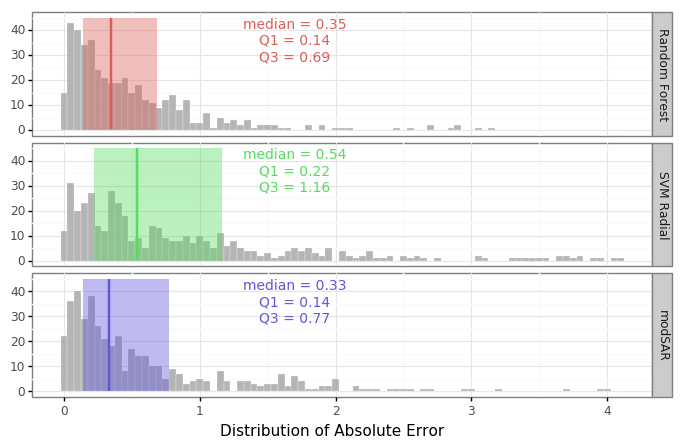

<ggplot: (-9223363266355378081)>

In [81]:
plot_error_distribution('NYPR1', y_pos=45, x_pos=1.7)

### Dataset NPYR2

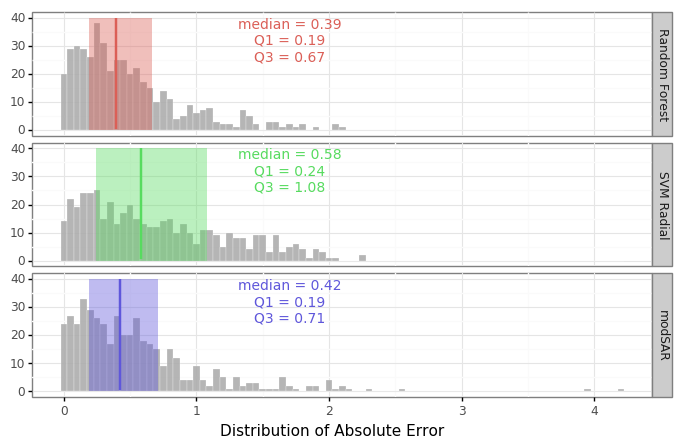

<ggplot: (-9223363266360120169)>

In [82]:
plot_error_distribution('NYPR2', x_pos=1.7)

### Dataset CHRM3

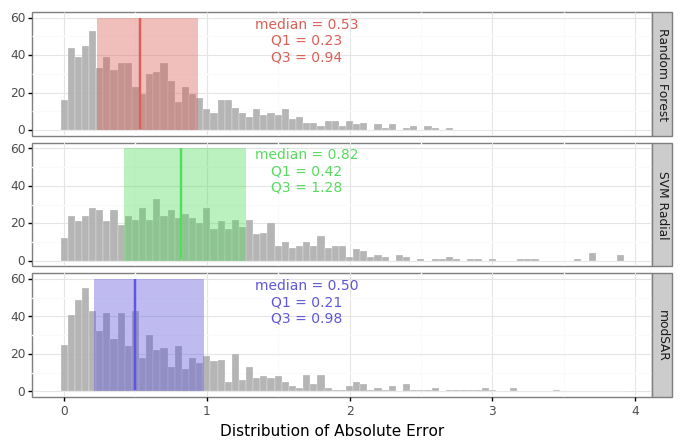

<ggplot: (8770494526998)>

In [83]:
plot_error_distribution('CHRM3', y_pos=60, x_pos=1.7)

### Dataset hDHFR

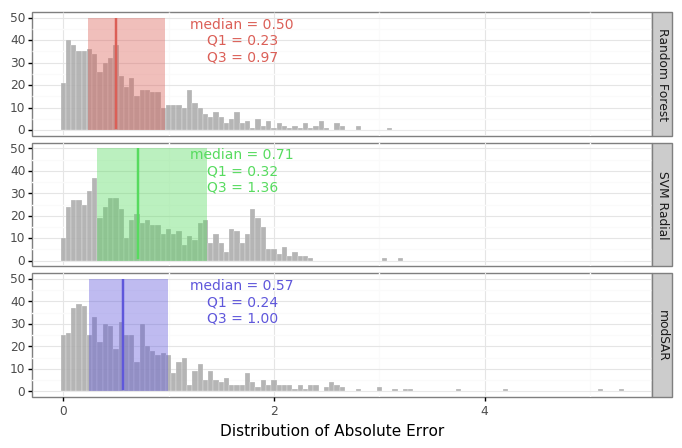

<ggplot: (8770494425692)>

In [84]:
plot_error_distribution('hDHFR', x_pos=1.7, y_pos=50)

### Dataset rDHFR

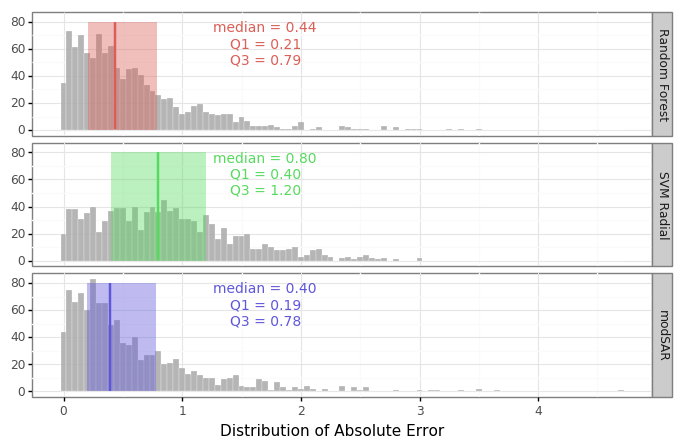

<ggplot: (8770494132814)>

In [85]:
plot_error_distribution('rDHFR', x_pos=1.7, y_pos=80)